C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3151
Estimator:                    PanelOLS   R-squared (Between):             -1.6053
No. Observations:                 2933   R-squared (Within):               0.1862
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -1.2652
Time:                         19:07:47   Log-likelihood                    699.52
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      32.188
Entities:                            2   P-value                           0.0000
Avg Obs:                        1466.5   Distribution:                 F(41,2868)
Min Obs:                        1303.0                                           
Max Obs:                        1630.0   F-statistic (robust):          3.864e+15
                

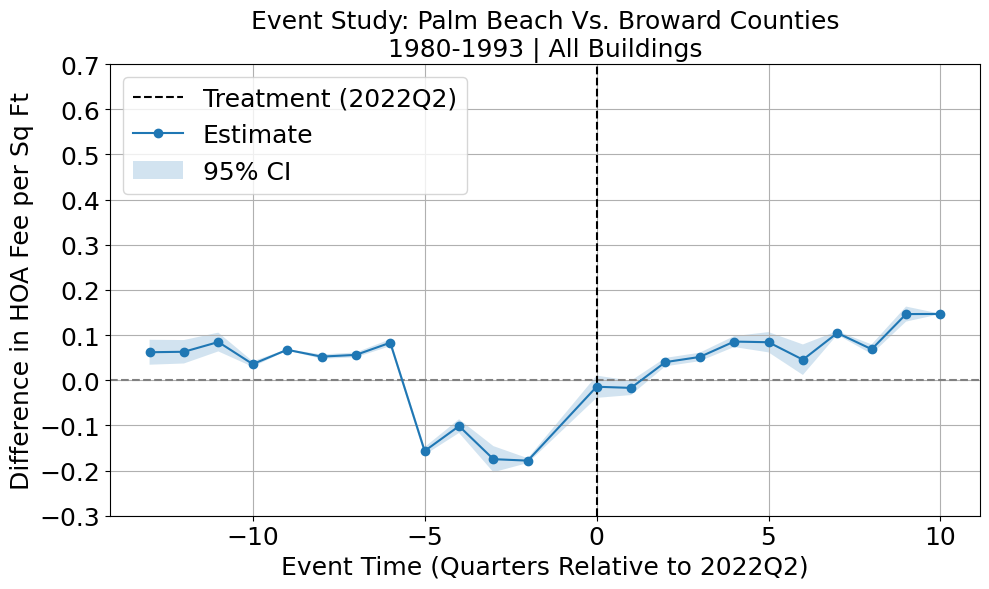

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3731
Estimator:                    PanelOLS   R-squared (Between):             -3.4070
No. Observations:                 1308   R-squared (Within):               0.2418
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -2.4645
Time:                         19:07:48   Log-likelihood                   -264.06
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      18.046
Entities:                            2   P-value                           0.0000
Avg Obs:                        654.00   Distribution:                 F(41,1243)
Min Obs:                        640.00                                           
Max Obs:                        668.00   F-statistic (robust):          8.761e+16
                

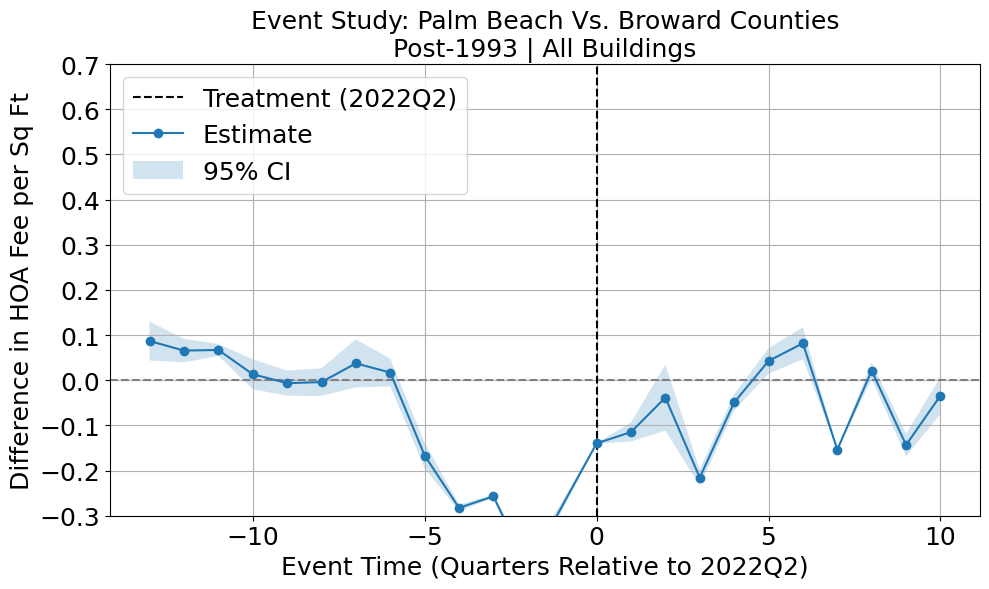

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2798
Estimator:                    PanelOLS   R-squared (Between):             -6.5229
No. Observations:                 5588   R-squared (Within):               0.2159
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -5.2473
Time:                         19:07:48   Log-likelihood                    1000.4
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      52.343
Entities:                            2   P-value                           0.0000
Avg Obs:                        2794.0   Distribution:                 F(41,5523)
Min Obs:                        1726.0                                           
Max Obs:                        3862.0   F-statistic (robust):          8.256e+16
                

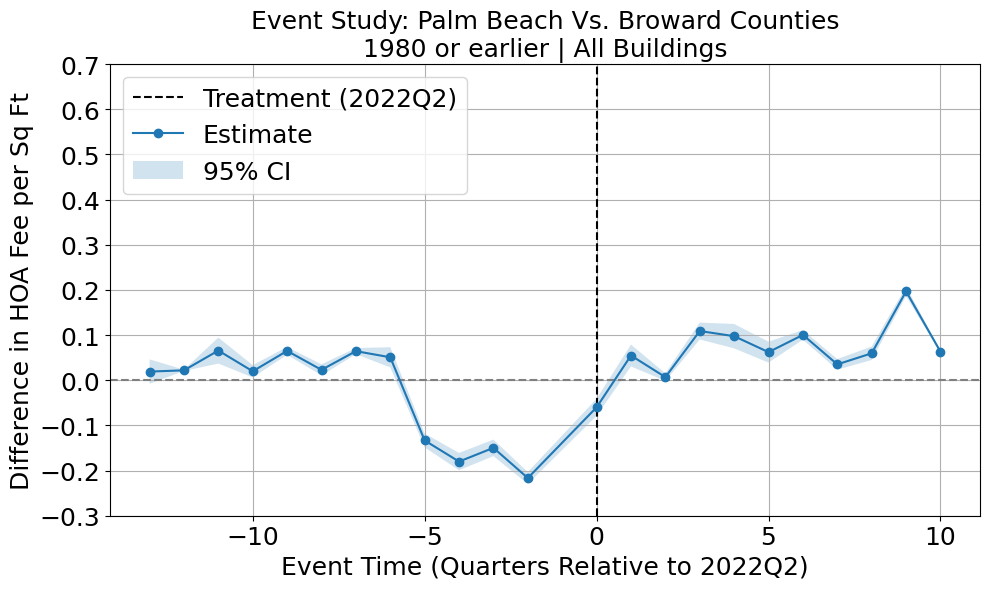

In [26]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np
import matplotlib.pyplot as plt


hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['PALM BEACH', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0

# --- Define filters ---
year_filters = {
    "1980-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1979) &
                 (merged['yr_blt_attom_assoc'] <= 1993),
    "Post-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1993),
    "1980 or earlier": (merged['yr_blt_attom_assoc'].notna()) &
                       (merged['yr_blt_attom_assoc'] <= 1979)
}

story_filters = {
    "All Buildings": (
        merged['num_stories_final_assoc'].notna()
    )
#     ,
#     "<10 Stories": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] < 10)    
#     )
#     "1-4": (
#         merged['num_stories_final_assoc'].notna() &
#         merged['num_stories_final_assoc'].isin([1, 2, 3, 4])
#     ),
#     "5-9": (
#         merged['num_stories_final_assoc'].notna() &
#         merged['num_stories_final_assoc'].isin([5, 6, 7, 8, 9])
#     ),
#     "10+": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] >= 10)
#     )
}


fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

merged['units_per_building'] = merged['num_units_final_assoc']/merged['num_bldgs_final_assoc']
merged['units_per_floor'] = merged['units_per_building']/merged['num_stories_final_assoc']

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

# Treated is now in Palm Beach county 
merged['treated_assoc'] = (merged['mm_fips_county_name_attom'] == "PALM BEACH").astype(int)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'garage_redfin_assoc', 'golf_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr', 'three_miles_coast_assoc', 'log_percap_income_prop_zip',
    'fema_2.0', 'fema_3.0', 'units_per_building', 'num_bldgs_final_assoc', 'units_per_floor'
]

# --- Loop over combinations ---
for y_label, y_cond in year_filters.items():
    for s_label, s_cond in story_filters.items():

        subset = merged[y_cond & s_cond].copy()

        # Set multi-index for panel regression: zip5_attom and quarter
        subset = subset.set_index(['mm_fips_county_name_attom', 'quarter'])

        # Dependent and exogenous variables
        y = subset['hoa_sq_ft_assoc_qtr']
        X = subset[event_dummies + covariates]

        # Fit model
        mod = PanelOLS(
            dependent=y,
            exog=X,
#             entity_effects=True,
            time_effects=True,
            weights=subset['final_weight'],
            drop_absorbed=True
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        print(res.summary)

        import matplotlib.pyplot as plt
        plt.rcParams.update({
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18
        })

        # Extract event-time interaction coefficients
        params = res.params
        conf_int = res.conf_int()
        event_times, coefs, ci_low, ci_high = [], [], [], []

        for col in event_dummies:
            k = int(col.split('_')[1])
            event_times.append(k)
            coefs.append(params[col])
            ci_low.append(conf_int.loc[col][0])
            ci_high.append(conf_int.loc[col][1])

        plot_df = pd.DataFrame({
            'event_time': event_times,
            'coef': coefs,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        }).sort_values('event_time')


        # Plot
        plt.figure(figsize=(10, 6))
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
        plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
        plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'],
                         alpha=0.2, label='95% CI')

        plt.title(f'Event Study: Palm Beach Vs. Broward Counties\n{y_label} | {s_label}')
        plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
        plt.ylabel('Difference in HOA Fee per Sq Ft', fontsize=18)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.ylim(-0.3, 0.7)
        plt.yticks(np.arange(-0.3, 0.71, 0.1))
        plt.tight_layout()

        # Save with dynamic filename
        # filename = f"output/plot_2021/zip_fe/event_study_{y_label}_{s_label}.png"
        # plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # print(f"Saved plot: {filename}")

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3130
Estimator:                    PanelOLS   R-squared (Between):             -1.7847
No. Observations:                 9829   R-squared (Within):               0.0469
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -1.4868
Time:                         19:09:54   Log-likelihood                    982.37
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      105.92
Entities:                           88   P-value                           0.0000
Avg Obs:                        111.69   Distribution:                 F(42,9763)
Min Obs:                        1.0000                                           
Max Obs:                        868.00   F-statistic (robust):             52.123
                

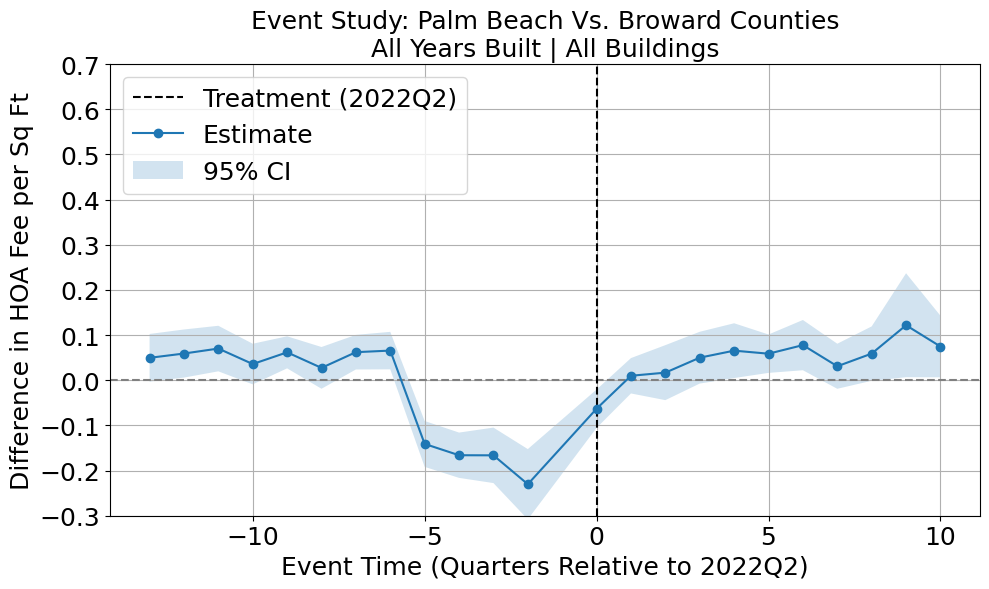

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3631
Estimator:                    PanelOLS   R-squared (Between):             -1.4545
No. Observations:                 2933   R-squared (Within):               0.0066
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -1.2577
Time:                         19:09:55   Log-likelihood                    805.88
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      38.909
Entities:                           82   P-value                           0.0000
Avg Obs:                        35.768   Distribution:                 F(42,2867)
Min Obs:                        1.0000                                           
Max Obs:                        134.00   F-statistic (robust):             48.044
                

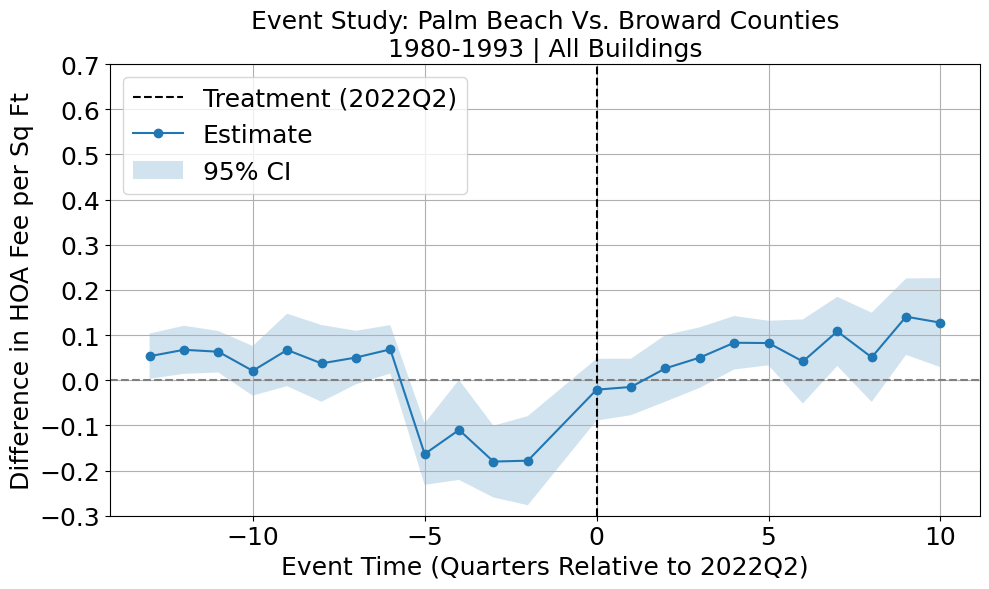

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3776
Estimator:                    PanelOLS   R-squared (Between):             -2.1294
No. Observations:                 1308   R-squared (Within):               0.0185
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -1.7714
Time:                         19:09:55   Log-likelihood                   -259.35
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      17.943
Entities:                           54   P-value                           0.0000
Avg Obs:                        24.222   Distribution:                 F(42,1242)
Min Obs:                        1.0000                                           
Max Obs:                        157.00   F-statistic (robust):             104.14
                

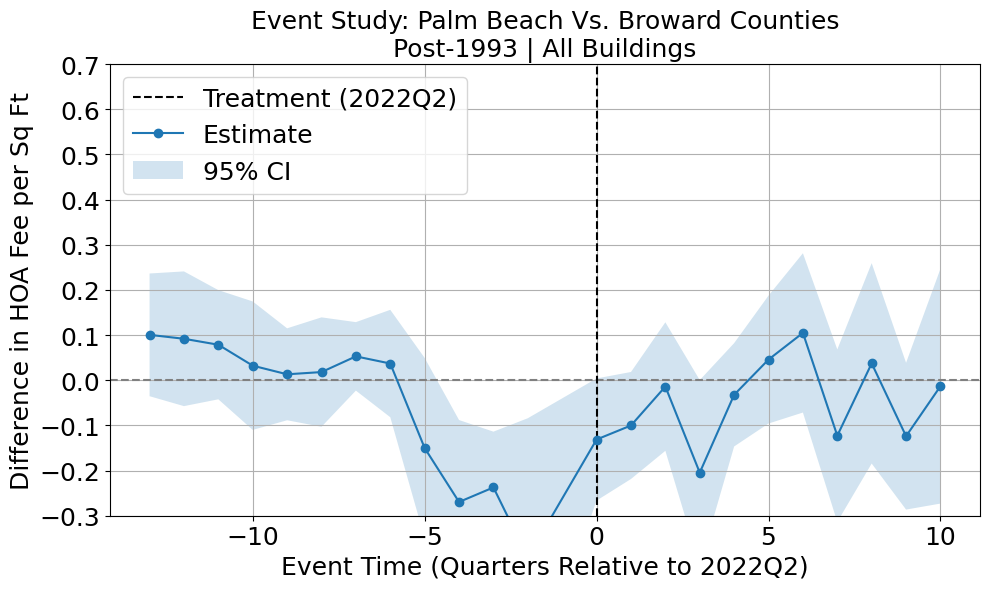

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2918
Estimator:                    PanelOLS   R-squared (Between):             -5.9289
No. Observations:                 5588   R-squared (Within):               0.0967
Date:                 Wed, Aug 13 2025   R-squared (Overall):             -5.0228
Time:                         19:09:56   Log-likelihood                    1047.2
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      54.170
Entities:                           75   P-value                           0.0000
Avg Obs:                        74.507   Distribution:                 F(42,5522)
Min Obs:                        1.0000                                           
Max Obs:                        681.00   F-statistic (robust):             166.61
                

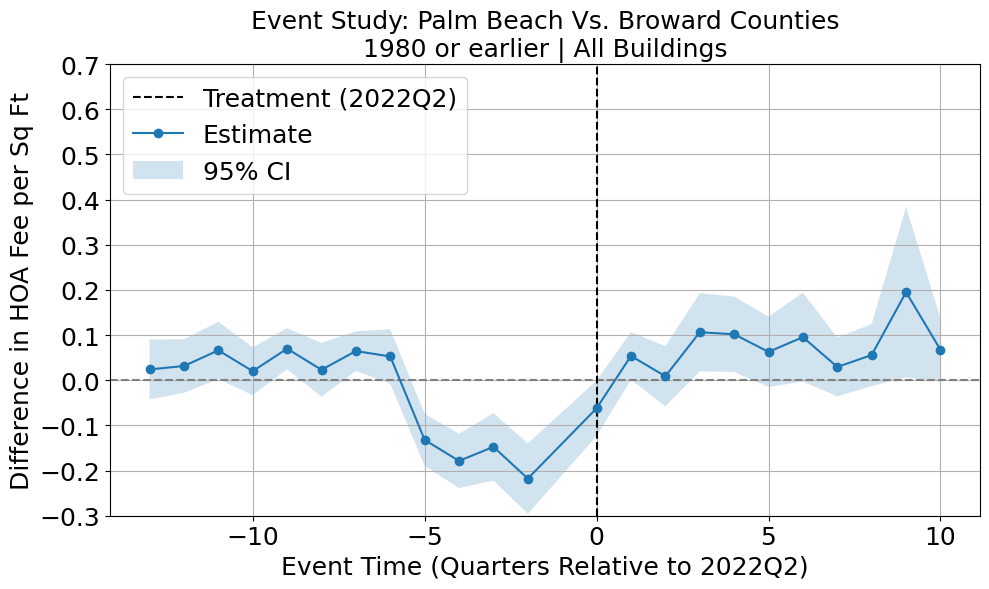

In [28]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np
import matplotlib.pyplot as plt


hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['PALM BEACH', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0

# List of ZIP codes from both maps (southern Palm Beach and Northern Broward)
target_zips = [
    33076, 33067, 33073, 33442, 33441, 33065, 33063, 33066, 33062,
    33071, 33321, 33068, 33319, 33309, 33334, 33351, 33313, 33312, 33308,
    33426, 33435, 33483, 33437, 33436, 33484, 33445, 33444, 33446, 33431,
    33432, 33434, 33433, 33486, 33496, 33487
]

# Subset dataframe
merged_subset = merged[merged["zip5_attom"].isin(target_zips)]

# --- Define filters ---
year_filters = {
    "All Years Built": (merged['yr_blt_attom_assoc'].notna()),
    "1980-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1979) &
                 (merged['yr_blt_attom_assoc'] <= 1993),
    "Post-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1993),
    "1980 or earlier": (merged['yr_blt_attom_assoc'].notna()) &
                       (merged['yr_blt_attom_assoc'] <= 1979)
}

story_filters = {
    "All Buildings": (
        merged['num_stories_final_assoc'].notna()
    )
#     ,
#     "<10 Stories": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] < 10)    
#     )
#     "1-4": (
#         merged['num_stories_final_assoc'].notna() &
#         merged['num_stories_final_assoc'].isin([1, 2, 3, 4])
#     ),
#     "5-9": (
#         merged['num_stories_final_assoc'].notna() &
#         merged['num_stories_final_assoc'].isin([5, 6, 7, 8, 9])
#     ),
#     "10+": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] >= 10)
#     )
}


fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

merged['units_per_building'] = merged['num_units_final_assoc']/merged['num_bldgs_final_assoc']
merged['units_per_floor'] = merged['units_per_building']/merged['num_stories_final_assoc']

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

# Treated is now in Palm Beach county 
merged['treated_assoc'] = (merged['mm_fips_county_name_attom'] == "PALM BEACH").astype(int)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'garage_redfin_assoc', 'golf_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr', 'three_miles_coast_assoc', 'log_percap_income_prop_zip',
    'fema_2.0', 'fema_3.0', 'units_per_building', 'num_bldgs_final_assoc', 'units_per_floor', 'num_stories_final_assoc'
]

# --- Loop over combinations ---
for y_label, y_cond in year_filters.items():
    for s_label, s_cond in story_filters.items():

        subset = merged[y_cond & s_cond].copy()

        # Set multi-index for panel regression: zip5_attom and quarter
        subset = subset.set_index(['zip5_attom', 'quarter'])

        # Dependent and exogenous variables
        y = subset['hoa_sq_ft_assoc_qtr']
        X = subset[event_dummies + covariates]

        # Fit model
        mod = PanelOLS(
            dependent=y,
            exog=X,
#             entity_effects=True,
            time_effects=True,
            weights=subset['final_weight'],
            drop_absorbed=True
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        print(res.summary)

        import matplotlib.pyplot as plt
        plt.rcParams.update({
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18
        })

        # Extract event-time interaction coefficients
        params = res.params
        conf_int = res.conf_int()
        event_times, coefs, ci_low, ci_high = [], [], [], []

        for col in event_dummies:
            k = int(col.split('_')[1])
            event_times.append(k)
            coefs.append(params[col])
            ci_low.append(conf_int.loc[col][0])
            ci_high.append(conf_int.loc[col][1])

        plot_df = pd.DataFrame({
            'event_time': event_times,
            'coef': coefs,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        }).sort_values('event_time')


        # Plot
        plt.figure(figsize=(10, 6))
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
        plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
        plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'],
                         alpha=0.2, label='95% CI')

        plt.title(f'Event Study: Palm Beach Vs. Broward Counties\n{y_label} | {s_label}')
        plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
        plt.ylabel('Difference in HOA Fee per Sq Ft', fontsize=18)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.ylim(-0.3, 0.7)
        plt.yticks(np.arange(-0.3, 0.71, 0.1))
        plt.tight_layout()

        # Save with dynamic filename
        # filename = f"output/plot_2021/zip_fe/event_study_{y_label}_{s_label}.png"
        # plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # print(f"Saved plot: {filename}")

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3165
Estimator:                    PanelOLS   R-squared (Between):             -2.7178
No. Observations:                 9829   R-squared (Within):               0.2155
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -2.1008
Time:                         08:54:29   Log-likelihood                    1007.3
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      107.64
Entities:                            2   P-value                           0.0000
Avg Obs:                        4914.5   Distribution:                 F(42,9763)
Min Obs:                        3697.0                                           
Max Obs:                        6132.0   F-statistic (robust):          2.202e+17
                

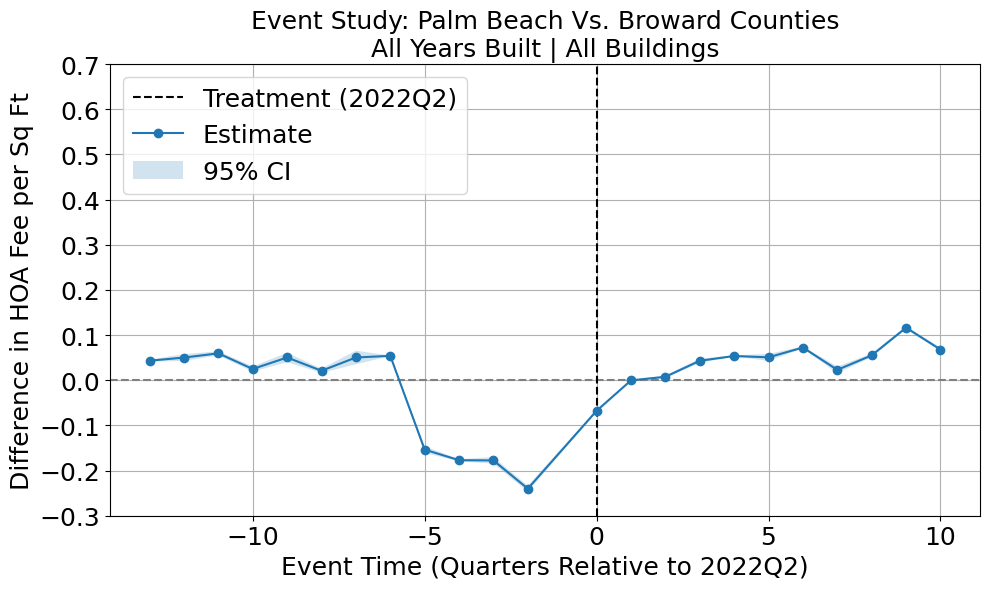

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3048
Estimator:                    PanelOLS   R-squared (Between):             -2.8053
No. Observations:                 7869   R-squared (Within):               0.1953
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -2.1951
Time:                         08:54:30   Log-likelihood                    469.57
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      81.468
Entities:                            2   P-value                           0.0000
Avg Obs:                        3934.5   Distribution:                 F(42,7803)
Min Obs:                        2747.0                                           
Max Obs:                        5122.0   F-statistic (robust):          9.788e+16
                

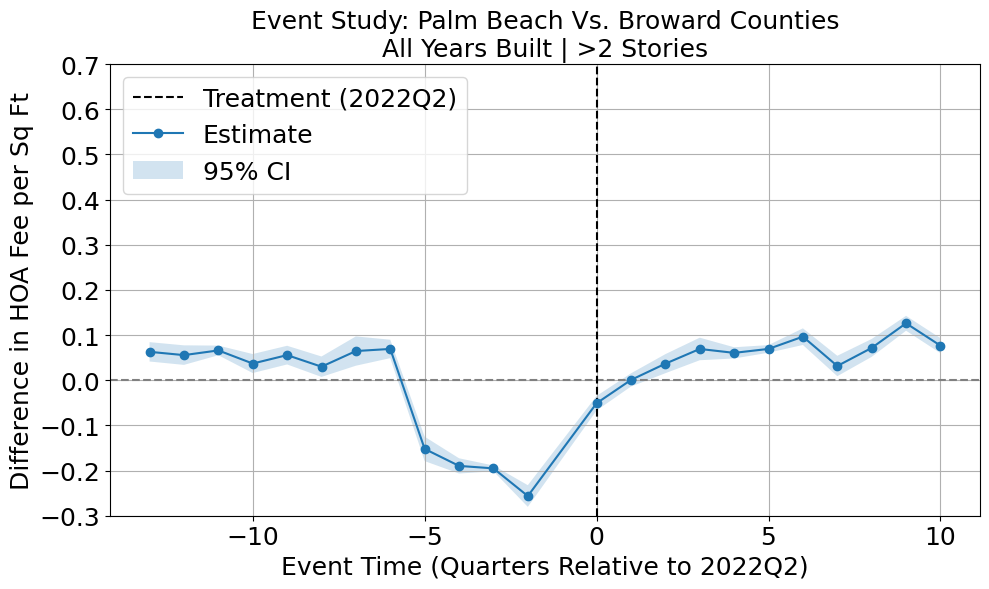

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1751
Estimator:                    PanelOLS   R-squared (Between):             -1.5798
No. Observations:                 3629   R-squared (Within):               0.0881
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -1.3260
Time:                         08:54:30   Log-likelihood                    1338.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      18.010
Entities:                            2   P-value                           0.0000
Avg Obs:                        1814.5   Distribution:                 F(42,3563)
Min Obs:                        1025.0                                           
Max Obs:                        2604.0   F-statistic (robust):          3.485e+16
                

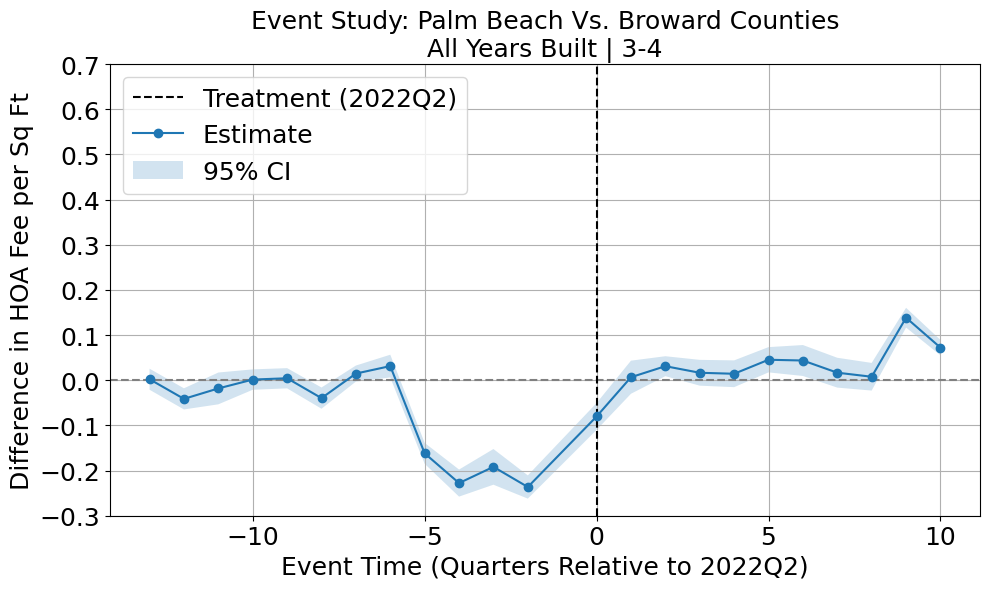

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1923
Estimator:                    PanelOLS   R-squared (Between):             -1.0683
No. Observations:                 1960   R-squared (Within):               0.1307
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -0.8551
Time:                         08:54:31   Log-likelihood                    738.64
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      10.737
Entities:                            2   P-value                           0.0000
Avg Obs:                        980.00   Distribution:                 F(42,1894)
Min Obs:                        950.00                                           
Max Obs:                        1010.0   F-statistic (robust):          2.908e+16
                

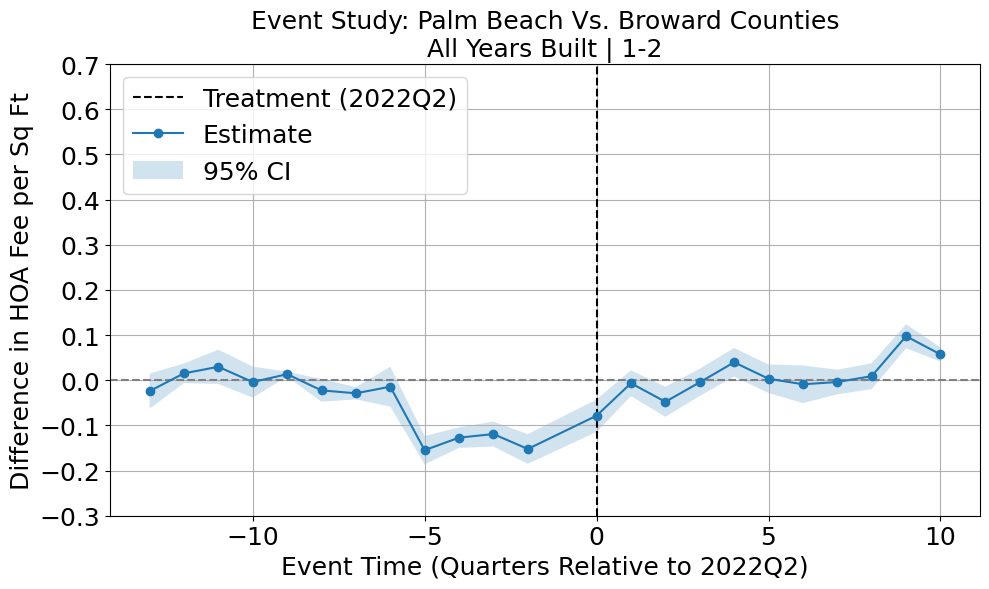

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3673
Estimator:                    PanelOLS   R-squared (Between):             -3.6609
No. Observations:                 2933   R-squared (Within):               0.2387
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -2.9205
Time:                         08:54:31   Log-likelihood                    815.61
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      39.622
Entities:                            2   P-value                           0.0000
Avg Obs:                        1466.5   Distribution:                 F(42,2867)
Min Obs:                        1303.0                                           
Max Obs:                        1630.0   F-statistic (robust):          1.646e+16
                

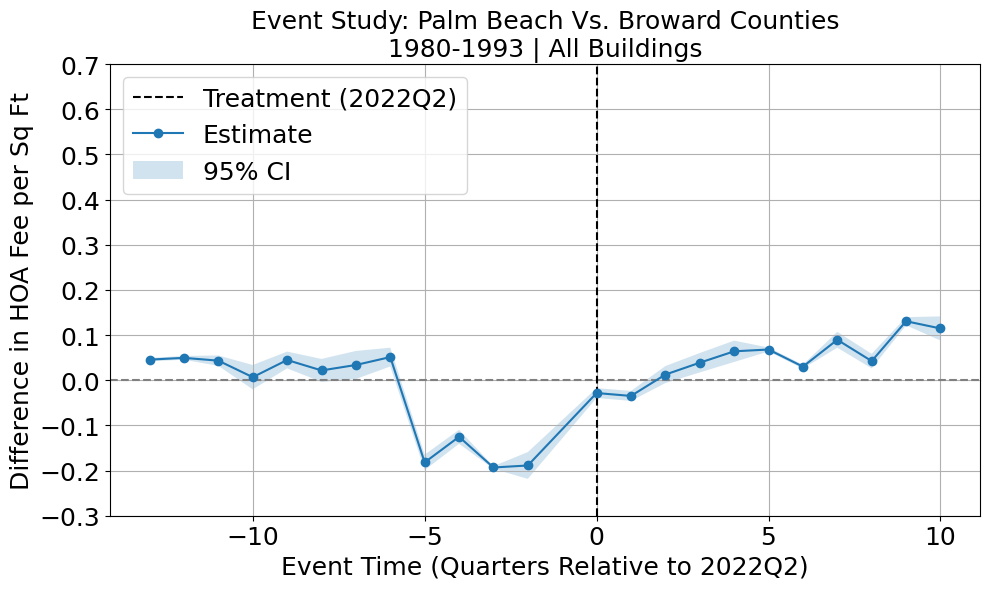

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3558
Estimator:                    PanelOLS   R-squared (Between):             -3.7227
No. Observations:                 2238   R-squared (Within):               0.2278
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -2.9987
Time:                         08:54:32   Log-likelihood                    515.96
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      28.561
Entities:                            2   P-value                           0.0000
Avg Obs:                        1119.0   Distribution:                 F(42,2172)
Min Obs:                        890.00                                           
Max Obs:                        1348.0   F-statistic (robust):         -5.693e+16
                

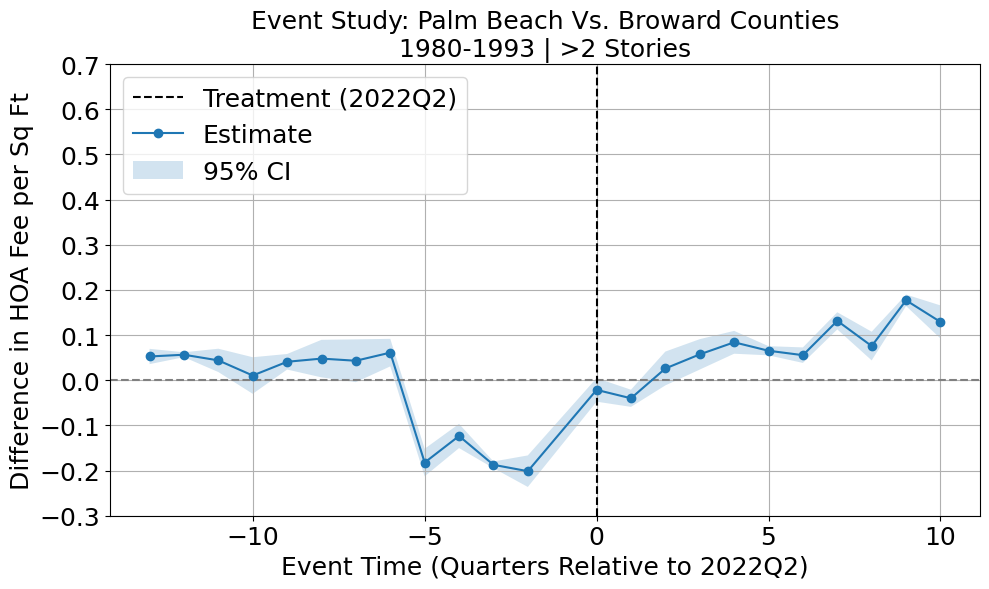

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2953
Estimator:                    PanelOLS   R-squared (Between):             -0.2314
No. Observations:                 1056   R-squared (Within):               0.0623
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -0.1901
Time:                         08:54:32   Log-likelihood                    528.00
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      9.8762
Entities:                            2   P-value                           0.0000
Avg Obs:                        528.00   Distribution:                  F(42,990)
Min Obs:                        358.00                                           
Max Obs:                        698.00   F-statistic (robust):         -8.554e+16
                

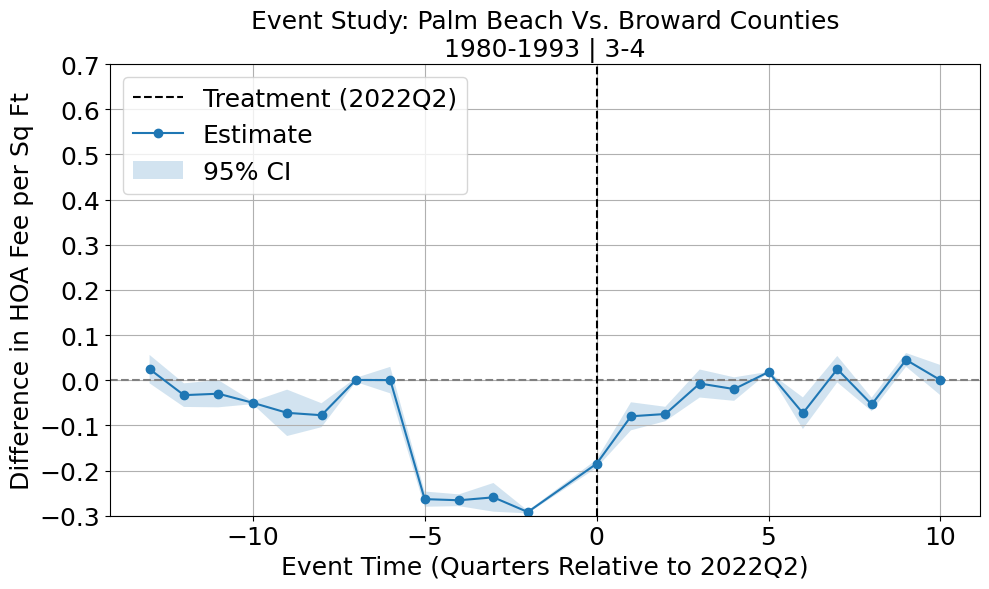

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2005
Estimator:                    PanelOLS   R-squared (Between):             -0.1787
No. Observations:                  695   R-squared (Within):               0.0677
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -0.1415
Time:                         08:54:33   Log-likelihood                    366.40
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      3.7556
Entities:                            2   P-value                           0.0000
Avg Obs:                        347.50   Distribution:                  F(42,629)
Min Obs:                        282.00                                           
Max Obs:                        413.00   F-statistic (robust):          1.204e+17
                

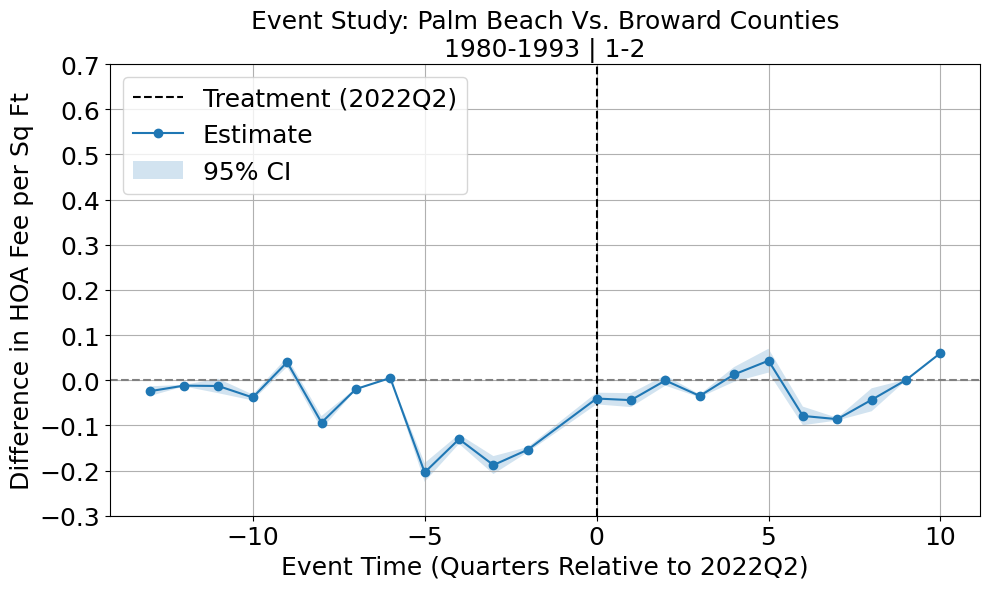

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3855
Estimator:                    PanelOLS   R-squared (Between):             -2.6438
No. Observations:                 1308   R-squared (Within):               0.2511
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -1.8961
Time:                         08:54:33   Log-likelihood                   -251.02
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      18.552
Entities:                            2   P-value                           0.0000
Avg Obs:                        654.00   Distribution:                 F(42,1242)
Min Obs:                        640.00                                           
Max Obs:                        668.00   F-statistic (robust):         -1.249e+15
                

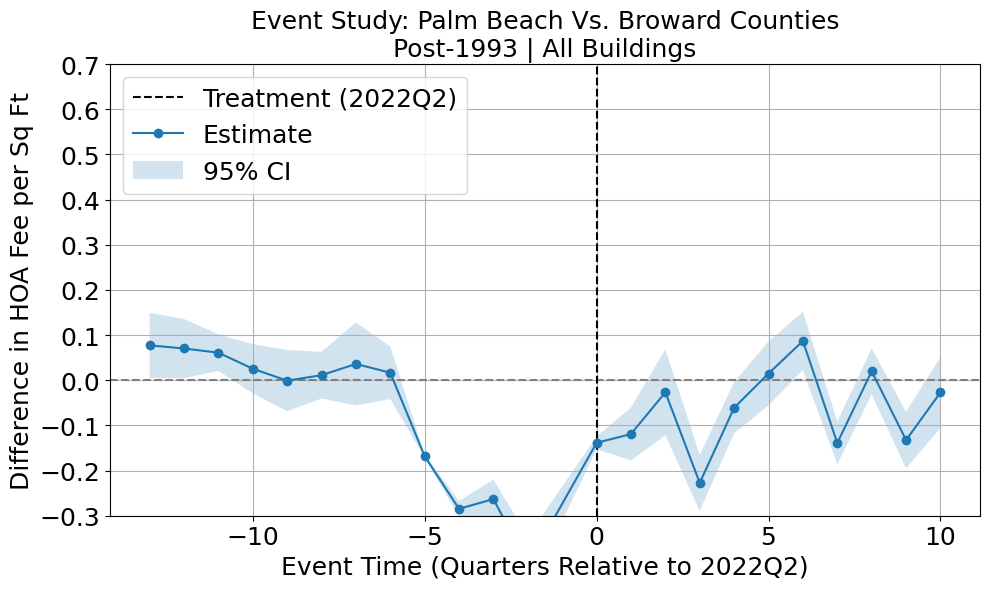

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3754
Estimator:                    PanelOLS   R-squared (Between):             -3.1992
No. Observations:                 1244   R-squared (Within):               0.2268
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -2.3396
Time:                         08:54:34   Log-likelihood                   -255.24
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      16.855
Entities:                            2   P-value                           0.0000
Avg Obs:                        622.00   Distribution:                 F(42,1178)
Min Obs:                        603.00                                           
Max Obs:                        641.00   F-statistic (robust):         -7.371e+15
                

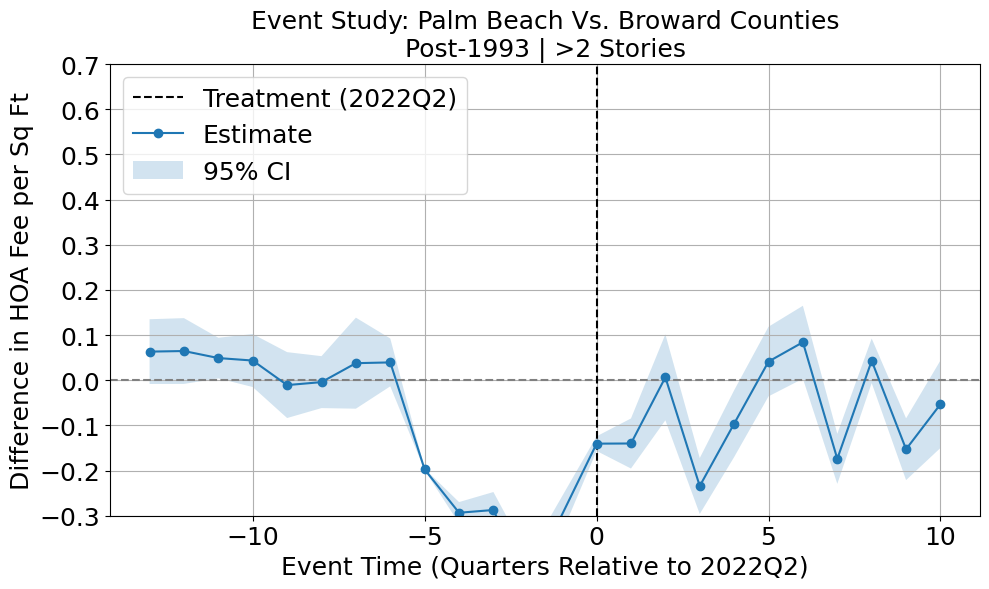

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.4867
Estimator:                    PanelOLS   R-squared (Between):             -1.3430
No. Observations:                  428   R-squared (Within):               0.3263
Date:                 Thu, Aug 14 2025   R-squared (Overall):             -0.9675
Time:                         08:54:34   Log-likelihood                    172.11
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      8.1709
Entities:                            2   P-value                           0.0000
Avg Obs:                        214.00   Distribution:                  F(42,362)
Min Obs:                        167.00                                           
Max Obs:                        261.00   F-statistic (robust):          4.638e+14
                

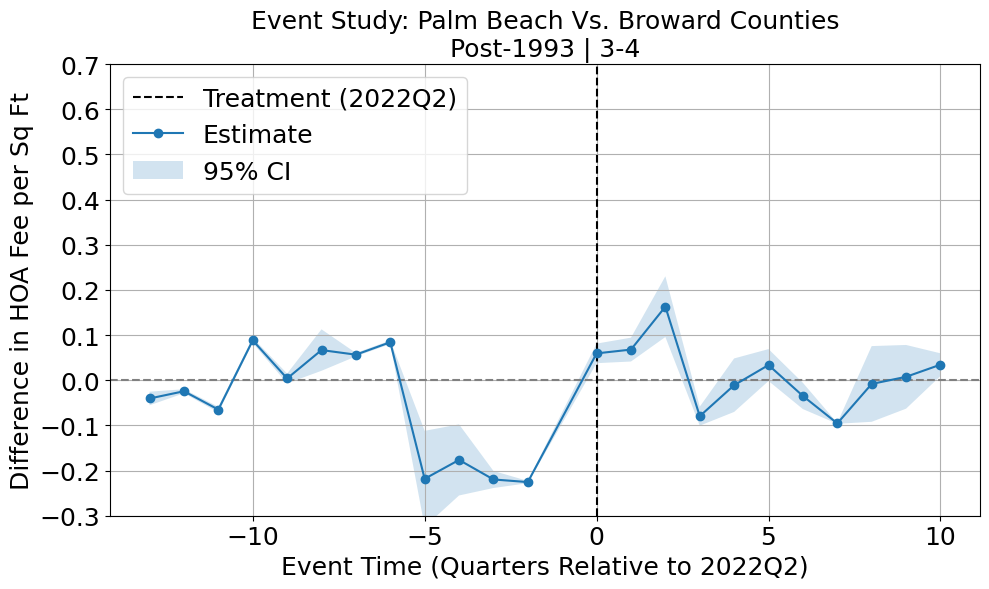

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

In [31]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np
import matplotlib.pyplot as plt


hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['PALM BEACH', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0

# List of ZIP codes from both maps (southern Palm Beach and Northern Broward)
target_zips = [
    33076, 33067, 33073, 33442, 33441, 33065, 33063, 33066, 33062,
    33071, 33321, 33068, 33319, 33309, 33334, 33351, 33313, 33312, 33308,
    33426, 33435, 33483, 33437, 33436, 33484, 33445, 33444, 33446, 33431,
    33432, 33434, 33433, 33486, 33496, 33487
]

# Subset dataframe
merged_subset = merged[merged["zip5_attom"].isin(target_zips)]

# --- Define filters ---
year_filters = {
    "All Years Built": (merged['yr_blt_attom_assoc'].notna()),
    "1980-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1979) &
                 (merged['yr_blt_attom_assoc'] <= 1993),
    "Post-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1993),
    "1980 or earlier": (merged['yr_blt_attom_assoc'].notna()) &
                       (merged['yr_blt_attom_assoc'] <= 1979)
}

story_filters = {
    "All Buildings": (
        merged['num_stories_final_assoc'].notna()
    )
    ,
    ">2 Stories": (
        merged['num_stories_final_assoc'].notna() &
         (merged['num_stories_final_assoc'] > 2)    
    )
     ,
    "3-4": (
        merged['num_stories_final_assoc'].notna() &
        merged['num_stories_final_assoc'].isin([3, 4])
    ),
#     "<10 Stories": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] < 10)    
#     )
    "1-2": (
        merged['num_stories_final_assoc'].notna() &
        merged['num_stories_final_assoc'].isin([1, 2])
    )
#     ,
#     "5-9": (
#         merged['num_stories_final_assoc'].notna() &
#         merged['num_stories_final_assoc'].isin([5, 6, 7, 8, 9])
#     ),
#     "10+": (
#         merged['num_stories_final_assoc'].notna() &
#          (merged['num_stories_final_assoc'] >= 10)
#     )
}


fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

merged['units_per_building'] = merged['num_units_final_assoc']/merged['num_bldgs_final_assoc']
merged['units_per_floor'] = merged['units_per_building']/merged['num_stories_final_assoc']

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

# Treated is now in Palm Beach county 
merged['treated_assoc'] = (merged['mm_fips_county_name_attom'] == "PALM BEACH").astype(int)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'garage_redfin_assoc', 'golf_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0', 'units_per_building', 'num_bldgs_final_assoc', 'units_per_floor', 
    'num_stories_final_assoc', 'log_percap_income_prop_zip', 'miles_to_coast_assoc'
]

# --- Loop over combinations ---
for y_label, y_cond in year_filters.items():
    for s_label, s_cond in story_filters.items():

        subset = merged[y_cond & s_cond].copy()

        # Set multi-index for panel regression: quarter
        subset = subset.set_index(['mm_fips_county_name_attom', 'quarter'])

        # Dependent and exogenous variables
        y = subset['hoa_sq_ft_assoc_qtr']
        X = subset[event_dummies + covariates]

        # Fit model
        mod = PanelOLS(
            dependent=y,
            exog=X,
#             entity_effects=True,
            time_effects=True,
            weights=subset['final_weight'],
            drop_absorbed=True
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        print(res.summary)

        import matplotlib.pyplot as plt
        plt.rcParams.update({
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18
        })

        # Extract event-time interaction coefficients
        params = res.params
        conf_int = res.conf_int()
        event_times, coefs, ci_low, ci_high = [], [], [], []

        for col in event_dummies:
            k = int(col.split('_')[1])
            event_times.append(k)
            coefs.append(params[col])
            ci_low.append(conf_int.loc[col][0])
            ci_high.append(conf_int.loc[col][1])

        plot_df = pd.DataFrame({
            'event_time': event_times,
            'coef': coefs,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        }).sort_values('event_time')


        # Plot
        plt.figure(figsize=(10, 6))
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
        plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
        plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'],
                         alpha=0.2, label='95% CI')

        plt.title(f'Event Study: Palm Beach Vs. Broward Counties\n{y_label} | {s_label}')
        plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
        plt.ylabel('Difference in HOA Fee per Sq Ft', fontsize=18)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.ylim(-0.3, 0.7)
        plt.yticks(np.arange(-0.3, 0.71, 0.1))
        plt.tight_layout()

        # Save with dynamic filename
        # filename = f"output/plot_2021/zip_fe/event_study_{y_label}_{s_label}.png"
        # plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # print(f"Saved plot: {filename}")